# AESM5110C Exercise

You can execute the code boxes by first selecting them with the mouse and then pressing Shift+Enter.

Util functions and setup code boxes must be run for the notebook to work.

## Util functions

In [1]:
import numpy as np

def create_results_dict(
        input
    ):
    """ Returns results as a dictionary, to make it easier to compare between runs. """

    nt, dt, time_array, T_parcel_array, P_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
    qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
    spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
    rc_liq_avg_array, rc_liq_std_array, TAU_ts_array, albedo_array = input

    results = {
        'nt': nt, 'dt': dt, 'time': time_array, 'T_parcel': T_parcel_array, 'P_parcel': P_parcel_array, 'RH_parcel': RH_parcel_array, 'q_parcel': q_parcel_array, 'z_parcel': z_parcel_array,
        'qa': qa_ts, 'qc': qc_ts, 'qr': qr_ts, 'na': na_ts, 'nc': nc_ts, 'nr': nr_ts,
        'spectra': spectra_arr, 'con': con_ts, 'act': act_ts, 'evp': evp_ts, 'dea': dea_ts, 'acc': acc_ts, 'aut': aut_ts, 'precip': precip_ts, 'particles': particles_array,
        'rc_liq_avg': rc_liq_avg_array, 'rc_liq_std': rc_liq_std_array, 'tau': TAU_ts_array, 'albedo': albedo_array
    }
    
    return results


def rwp(results, w):
    """ Calculate rainwater path from results dict. """
    from PyLCM.parcel import parcel_rho

    rho_parcel_array, _, _ = parcel_rho(results['P_parcel'], results['T_parcel'])

    return np.cumsum(rho_parcel_array * results['qr'] * w * results['dt'])


def extract_widget_inputs(
        n_particles_widget, P_widget, RH_widget, T_widget, w_widget, nt_widget, dt_widget, rm_spec, ascending_mode_widget, mode_displaytype_widget, z_widget, max_z_widget,
        Condensation_widget, Collision_widget, mode_aero_init_widget, gridwidget, kohler_widget, hygroscopicity_widget, switch_sedi_removal_widget,
        entrainment_rate_widget, entrainment_widget, entrainment_start_widget, entrainment_end_widget
        ):
    """ Convert widget input parameters to raw values to input to model. """
    
    # Model steering parameters
    dt = dt_widget.value
    nt = nt_widget.value

    do_condensation = Condensation_widget.value
    do_collision    = Collision_widget.value

    n_particles = n_particles_widget.value

    # Parcel initial parameters
    T_parcel   = T_widget.value
    P_parcel   = P_widget.value
    RH_parcel  = RH_widget.value
    w_parcel   = w_widget.value
    z_parcel   = z_widget.value

    max_z = max_z_widget.value

    ascending_mode  = ascending_mode_widget.value

    display_mode    = mode_displaytype_widget.value
    
    # Aerosol initialization
    mode_aero_init = mode_aero_init_widget.value

    # Read in the variables given above taking into account unit factors
    N_aero     = [gridwidget[1, 0].value*1.0E6, gridwidget[1, 1].value*1.0E6, gridwidget[1, 2].value*1.0E6, gridwidget[1, 3].value*1.0E6]
    mu_aero    = [gridwidget[2, 0].value*1.0E-6, gridwidget[2, 1].value*1.0E-6, gridwidget[2, 2].value*1.0E-6, gridwidget[2, 3].value*1.0E-6]
    sigma_aero = [gridwidget[3, 0].value, gridwidget[3, 1].value, gridwidget[3, 2].value, gridwidget[3, 3].value]
    k_aero     = [gridwidget[4, 0].value, gridwidget[4, 1].value, gridwidget[4, 2].value, gridwidget[4, 3].value]

    kohler_activation_radius    = kohler_widget.value
    switch_kappa_koehler        = hygroscopicity_widget.value
    switch_sedi_removal         = switch_sedi_removal_widget.value
    entrainment_rate            = entrainment_rate_widget.value
    switch_entrainment          = entrainment_widget.value
    entrainment_start           = entrainment_start_widget.value
    entrainment_end             = entrainment_end_widget.value

    return \
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end

## Setup model

In [2]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *
# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

## User interface (initialise model with widgets)

You can use the user interface widgets below to initialise the model, if you find it more intuitive than the direct input.

### Model steering parameters

In [3]:
dt_widget, nt_widget, Condensation_widget, Collision_widget, switch_sedi_removal_widget, n_particles_widget, max_z_widget = model_steering_input()

'Model steering parameters'

BoundedFloatText(value=1.0, description='dt (s):', max=5.0, min=0.0001, style=DescriptionStyle(description_wid…

IntText(value=5000, description='nt:', style=DescriptionStyle(description_width='initial'))

Checkbox(value=True, description='Condensation', style=CheckboxStyle(description_width='initial'))

Checkbox(value=True, description='Collision', style=CheckboxStyle(description_width='initial'))

BoundedIntText(value=500, description='n_particles:', max=10000, min=100, style=DescriptionStyle(description_w…

BoundedFloatText(value=1200.0, description='z_max (m):', max=10000.0, step=0.1, style=DescriptionStyle(descrip…

### Parcel parameters

In [4]:
T_widget, P_widget, RH_widget, w_widget, z_widget = parcel_info_input()

ascending_mode_widget = ascending_mode_input()

'Parcel initial parameters: '

BoundedFloatText(value=289.27, description='T (K):', max=320.0, min=200.0, step=0.1, style=DescriptionStyle(de…

BoundedFloatText(value=101181.0, description='P (Pa):', max=105000.0, min=95000.0, step=1.0, style=Description…

BoundedFloatText(value=0.83, description='RH (-):', max=2.0, min=0.01, step=0.01, style=DescriptionStyle(descr…

BoundedFloatText(value=0.5, description='w (m/s):', max=10.0, step=0.1, style=DescriptionStyle(description_wid…

BoundedFloatText(value=0.0, description='z (m):', max=20000.0, step=100.0, style=DescriptionStyle(description_…

ToggleButtons(description='Mode', layout=Layout(width='max-content'), options=('linear', 'sine', 'in_cloud_osc…

### Entrainment parameters

In [5]:
entrainment_widget, stability_widget, entrainment_start_widget, entrainment_end_widget, entrainment_rate_widget  = entrainment_input()

'Entrainment parameters: '

Checkbox(value=False, description='Entrainment', style=CheckboxStyle(description_width='initial'))

ToggleButtons(description='Stability', layout=Layout(width='max-content'), options=('Stable', 'Unstable', 'Neu…

IntText(value=1000, description='Entrainment start time (s)', style=DescriptionStyle(description_width='initia…

IntText(value=1030, description='Entrainment end time (s)', style=DescriptionStyle(description_width='initial'…

FloatText(value=0.05, description='Fractional entrainment rate ($ \\mathrm{m}^{-1} $)', layout=Layout(width='m…

#### Create environment profile for entrainment

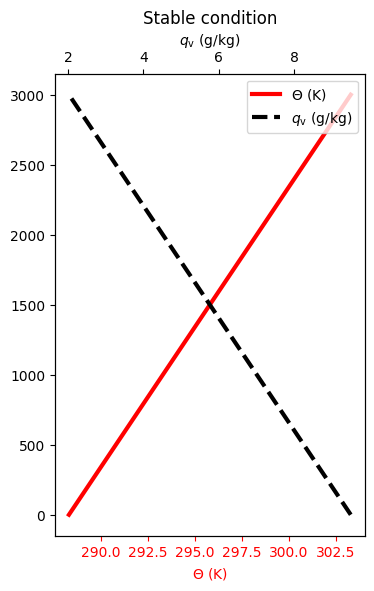

In [6]:
qv_init                             = RH_widget.value * esatw( T_widget.value ) / ( P_widget.value - RH_widget.value * esatw( T_widget.value ) ) * r_a / rv
qv_profiles, theta_profiles, z_env  = create_env_profiles(T_widget.value, qv_init, z_widget.value,P_widget.value, stability_widget.value)

### Aerosol parameters

In [7]:
# Use activation radius with kohler critical radius
kohler_widget = kohler_settings()
# Use hygroscopicity parameter, otherwise, sea-salt aerosols are initialized 
hygroscopicity_widget = kappa_settings()
# Choose the mode for aerosol initialization
mode_aero_init_widget = aero_mode_input()
# Initialization parameters for aerosol (up to 4 modes)
gridwidget = grid_modes_input()

'Set activation radius using Koehler critical radius, otherwise activation radius is 1 µm'

Checkbox(value=False, description='Koehler critical radius', layout=Layout(width='max-content'), style=Checkbo…

'Use hygroscopicity parameter from kappa-kohler theory'

Checkbox(value=False, description='Hygroscopicity', layout=Layout(width='max-content'), style=CheckboxStyle(de…

'Aerosol initialisation mode: '

ToggleButtons(layout=Layout(width='max-content'), options=('Random', 'Weighting_factor'), value='Random')

N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1', layout=Layout(grid_area='widget001…

## Timestep routine

In [8]:
# setting of display mode while running: either output of variables in text form (fast, recommended) = 'text'
# or: continuously updated plot using plotly (slow, time & memory consuming) = 'graphics'
mode_displaytype_widget = timestep_display_mode_settings()

'Display mode: '

ToggleButtons(index=1, layout=Layout(width='max-content'), options=('text_fast', 'graphics'), value='graphics'…

## Extract widget inputs

In [9]:
dt, nt, do_condensation, do_collision, n_particles, \
T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
rm_spec, ascending_mode, display_mode, \
mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
entrainment_rate, switch_entrainment, entrainment_start, entrainment_end = \
extract_widget_inputs(
    n_particles_widget, P_widget, RH_widget, T_widget, w_widget, nt_widget, dt_widget, rm_spec, ascending_mode_widget, mode_displaytype_widget, z_widget, max_z_widget,
    Condensation_widget, Collision_widget, mode_aero_init_widget, gridwidget, kohler_widget, hygroscopicity_widget, switch_sedi_removal_widget,
    entrainment_rate_widget, entrainment_widget, entrainment_start_widget, entrainment_end_widget
)

## Direct input (without widgets)

You can directly assign parameters in the code below rather than using the widgets. This can be more convenient as the widgets will override your original input when reloaded.

If you prefer to use the widget UI above, **do not run the code block directly below this one**. Instead, skip to 'Run model'.

In [10]:
%%capture
# ^ Don't show entrainment plot

# Model steering parameters

dt                  = 1 # s
nt                  = 5000
do_condensation     = True
do_collision        = True
switch_sedi_removal = False
n_particles         = 500
max_z               = 1200 # m


# Parcel initial parameters

T_parcel        = 289.27 # K
P_parcel        = 101181 # Pa
RH_parcel       = 0.83
w_parcel        = 0.5 # m s-1
z_parcel        = 0 # m
ascending_mode  = 'linear' # linear / sine / in_cloud_oscillation


# Entrainment parameters

entrainment         = False
stability           = 'Stable' # Stable / Unstable / Neutral
# entrainment_start   = 1000 # s
# entrainment_end     = 1030 # s
# entrainment_rate    = 0.05

# Even if you are not using entrainment, you need to calculate these
qv_init = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_widget.value ) ) * r_a / rv
qv_profiles, theta_profiles, z_env = create_env_profiles(T_parcel, qv_init, z_parcel, P_parcel, stability)


# Koehler theory

kohler_activation_radius    = False
switch_kappa_koehler        = False
mode_aero_init              = 'Random' # Random / Weighting_factor


# Initialisation parameters for aerosol (up to 4 modes)
# N_aero = number of aerosol per cm3 of air | mu = mean droplet radius | sigma = std. of mu | kappa = hygroscopicity parameter

# Mode #1
N_aero[0]       = 200e6 # N_aero (m-3)
mu_aero[0]      = 0.04e-6 # mu (m)
sigma_aero[0]   = 1.4 # sigma (-)
k_aero[0]       = 1.0 # kappa

# Mode #2
N_aero[1]       = 0 # N_aero (m-3)
mu_aero[1]      = 0 # mu (m)
sigma_aero[1]   = 0 # sigma (-)
k_aero[1]       = 0 # kappa

# Mode #3
N_aero[2]       = 0 # N_aero (m-3)
mu_aero[2]      = 0 # mu (m)
sigma_aero[2]   = 0 # sigma (-)
k_aero[2]       = 0 # kappa

# Mode #4
N_aero[3]       = 0 # N_aero (m-3)
mu_aero[3]      = 0 # mu (m)
sigma_aero[3]   = 0 # sigma (-)
k_aero[3]       = 0 # kappa


# Display mode

display_mode = 'text_fast' # text_fast / graphics

## Run model

In [11]:
test_run \
    = create_results_dict(timesteps_function(
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
        qv_profiles, theta_profiles
    ))

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 2400.0    1200.00  281.51   7.91      100.038   1.582     0.008     18.60     115.80    0.10      500     


## Exercises

In [12]:
# Tip: use major/minor locator and set_x/ylim in matplotlib to help answer the questions

import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

### Exercise 1: Tutorial

<div>
<img src="figs/parcel_model.png", width="800" />
</div>


The idea behind the cloud-parcel model is illustrated in the figure. Its governing equations are described in the reader.

#### Important notes for these exercises

1 ) A reminder: supersaturation is the condition of air where humidity is above the level of saturation at a given temperature, i.e. where relative humidity exceeds 100%. Therefore, we can relate supersaturation ($S$) to relative humidity ($RH$) as:

$S = RH - 100\%$

2 ) There is some stochasticity in the model, so expect slight variations in the outputs even when you run it multiple times with the same inputs. This can be addressed through ensemble averaging of outputs, however this is not currently implemented in the Python version of the model.

#### Exercise 1.1

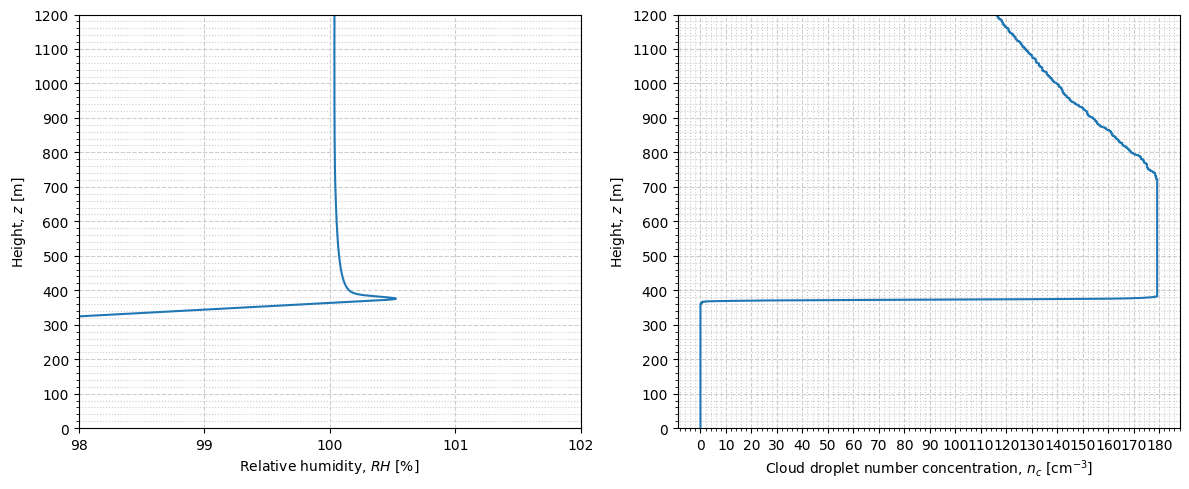

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))


# AX 1

axs[0].plot(test_run['RH_parcel']*100, test_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')

# Major ticks
axs[0].xaxis.set_major_locator(MultipleLocator(1))
axs[0].yaxis.set_major_locator(MultipleLocator(100))

# Minor ticks
axs[0].xaxis.set_minor_locator(AutoMinorLocator(1))
axs[0].yaxis.set_minor_locator(AutoMinorLocator(5))

axs[0].set_xlim(98,102)


# AX 2

axs[1].plot(test_run['nc'], test_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [cm$^{-3}$]')

# Major ticks
axs[1].xaxis.set_major_locator(MultipleLocator(10))
axs[1].yaxis.set_major_locator(MultipleLocator(100))

# Minor ticks
axs[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs[1].yaxis.set_minor_locator(AutoMinorLocator(5))


for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.set_ylim(test_run['z_parcel'][0],test_run['z_parcel'][-1])
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.tight_layout()
plt.show()

- At what height does the parcel reach its LCL?
- What is the concentration of cloud droplets at a height of 500 m?
- At what height is the cloud base located?
- When does the ascending parcel move through the base of the cloud?

### Exercise 1.2

Run a reference run of the model with the inputs below, leaving other inputs as set above.

- Plot 'relative humidity', 'cloud droplet number concentration' and 'mean droplet radius' for the new run.

In [14]:
# Reference values

ref_z_init = 0 # m
ref_z_max = 1700 # m

ref_w = 0.5 # m s-1

ref_N = 300e6 # m-3
ref_sigma = 2.0


In [15]:
z_parcel = ref_z_init
max_z = ref_z_max

N_aero[0] = ref_N # N_aero (m-3)
sigma_aero[0] = ref_sigma # sigma (-)

In [16]:
reference_run \
    = create_results_dict(timesteps_function(
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
        qv_profiles, theta_profiles
    ))

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 3400.0    1700.00  278.87   7.01      100.133   0.695     1.796     44.81     24.23     4.50      499     


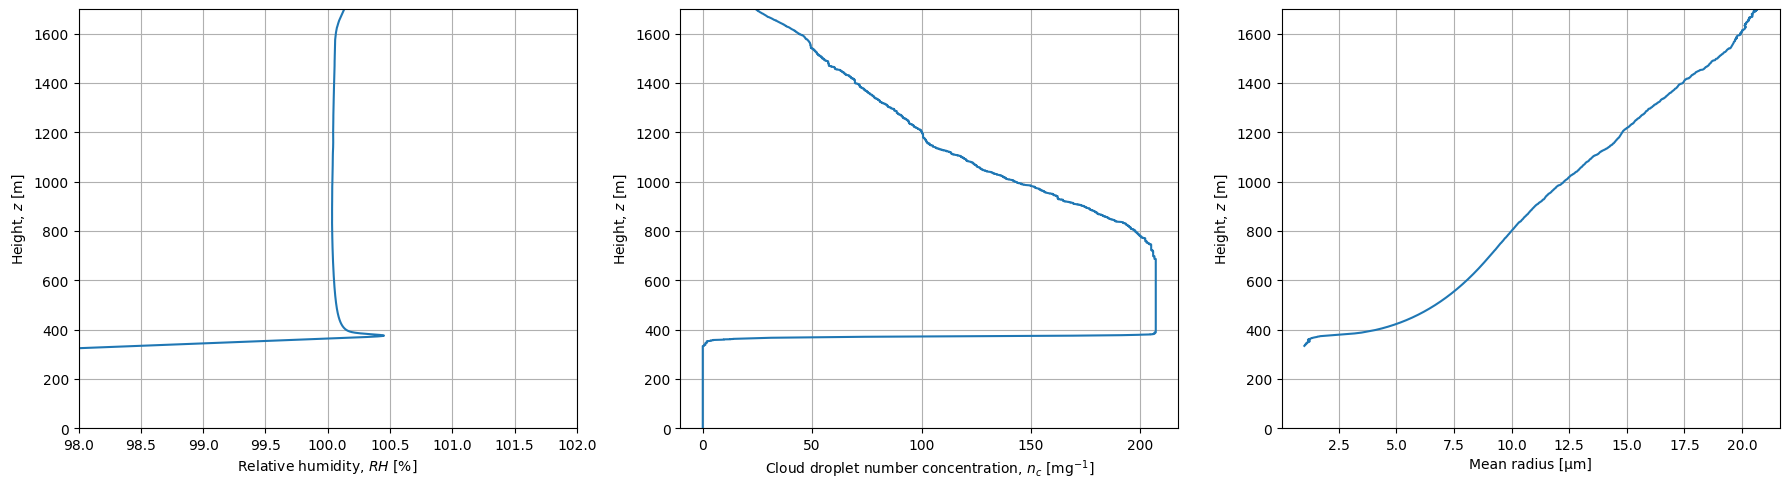

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')
axs[0].set_xlim(98,102)

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'])
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.set_ylim(reference_run['z_parcel'][0],reference_run['z_parcel'][-1])
    ax.grid()

plt.tight_layout()
plt.show()

### Exercise 1.3

The code box below plots a so-called spectrum of cloud droplet sizes. Execute it.

/var/folders/pm/yr9p5vts11g53s85rr_h4kw8tlv16r/T/ipykernel_8259/2458100818.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(1e6*rm_spec, reference_run['z_parcel'], reference_run['spectra'], norm=matplotlib.colors.LogNorm())#, levels=np.logspace(2, 10, 20))


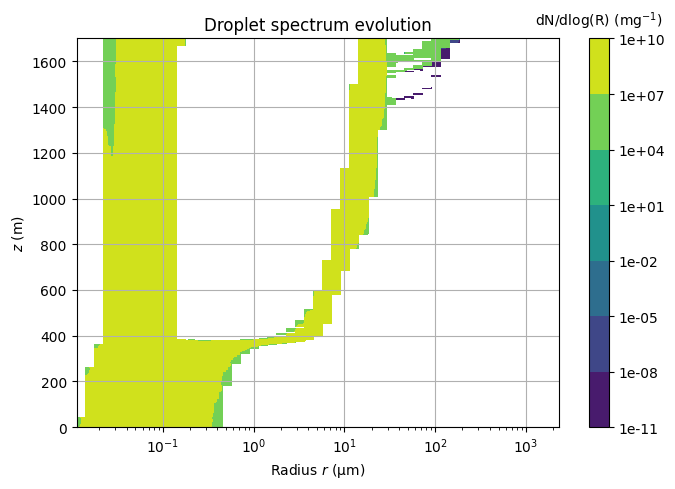

In [18]:
fig, ax = plt.subplots(figsize=(7,5))

contour = ax.contourf(1e6*rm_spec, reference_run['z_parcel'], reference_run['spectra'], norm=matplotlib.colors.LogNorm())#, levels=np.logspace(2, 10, 20))
cbar = plt.colorbar(contour, ax=ax, format="%.0e")

ax.set_title('Droplet spectrum evolution')
ax.set_xlabel('Radius $r$ (µm)')
ax.set_ylabel('$z$ (m)')
cbar.ax.set_title('dN/dlog(R) (mg$^{-1}$)', fontsize = 10, pad = 10)
ax.set_xscale('log')
ax.grid()

plt.tight_layout()
plt.show()

### Exercise 1.4

- Compare the plot of the droplet spectrum to the plot of mean radius. What do they have in common, how are they different? You may need to change to a log x scale on the mean radius plot to compare.
- The plot of the droplet number concentration features three different regimes. Explain which microphysical processes cause these three regimes. Refer to the droplet spectrum to support your explanation.

## Exercise 2: What controls the number of droplets in the parcel?

You are now equipped to investigate how the liquid number concentration is modified by different factors.

### Exercise 2.1: Influence of pollution

Anthropogenic emissions of fine particulate matter increase the concentration of aerosol particles.

- Study the effect of particulate pollution on the microphysical composition of a cloud by comparing the simulation from Exercise 1.2 to a new, more polluted, simulation where you double the number concentration of aerosol particles.

- Explain your plots by creating a conceptual diagram that relates aerosol number concentration, relative humidity (i.e. supersaturation), cloud droplet number and mean droplet radius. Which microphysical processes are important? How does your diagram relect the equations of the parcel model?

In [19]:
N_aero[0] = 2 * ref_N # N_aero (m-3)

In [20]:
polluted_run \
    = create_results_dict(timesteps_function(
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
        qv_profiles, theta_profiles
    ))

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 3400.0    1700.00  278.88   7.01      100.084   0.993     1.499     143.53    52.22     2.14      498     


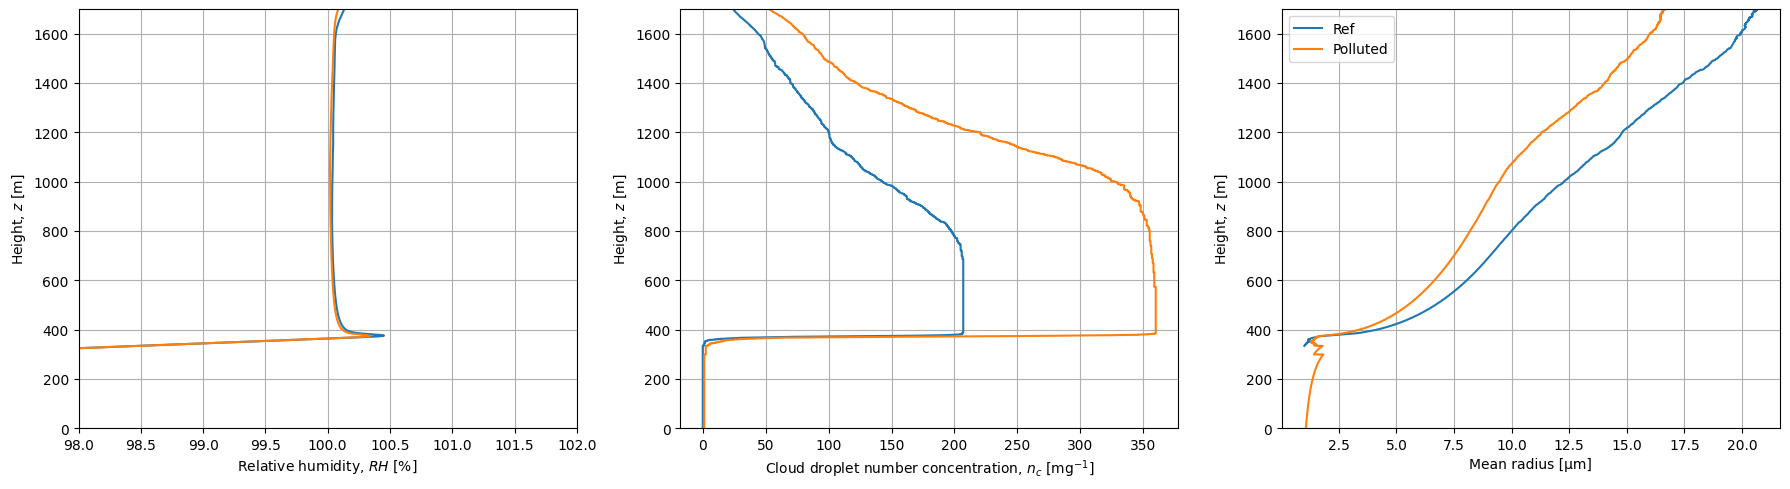

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].plot(polluted_run['RH_parcel']*100, polluted_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')
axs[0].set_xlim(98,102)

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].plot(polluted_run['nc'], polluted_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'], label="Ref")
axs[2].plot(polluted_run['rc_liq_avg']*1e6, polluted_run['z_parcel'], label="Polluted")
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.set_ylim(reference_run['z_parcel'][0],reference_run['z_parcel'][-1])
    ax.grid()

plt.legend()

plt.tight_layout()
plt.show()

### Exercise 2.2: Role of updraft speed

The updraft speed controls how fast the parcel ascends.

- Study the effect of different updraft speeds on the microphysical composition of a cloud by comparing the simulation ‘reference_run’ to a simulation ‘fast_run’ with a faster parcel ascent, where you double the updraft speed (parameter 'w_parcel').
- Explain your results by creating a conceptual diagram that relates updraft speed, supersaturation, cloud droplet number and mean droplet radius. Which microphysical processes are important? How does your diagram reflect the equations of the parcel model?

In [22]:
# Reset N to origiinal concentration
N_aero[0] = ref_N

w_parcel = 2 * ref_w # m s-1

In [23]:
fast_run \
    = create_results_dict(timesteps_function(
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
        qv_profiles, theta_profiles
    ))

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 1700.0    1700.00  278.88   7.01      100.047   2.255     0.239     50.40     121.65    3.07      500     


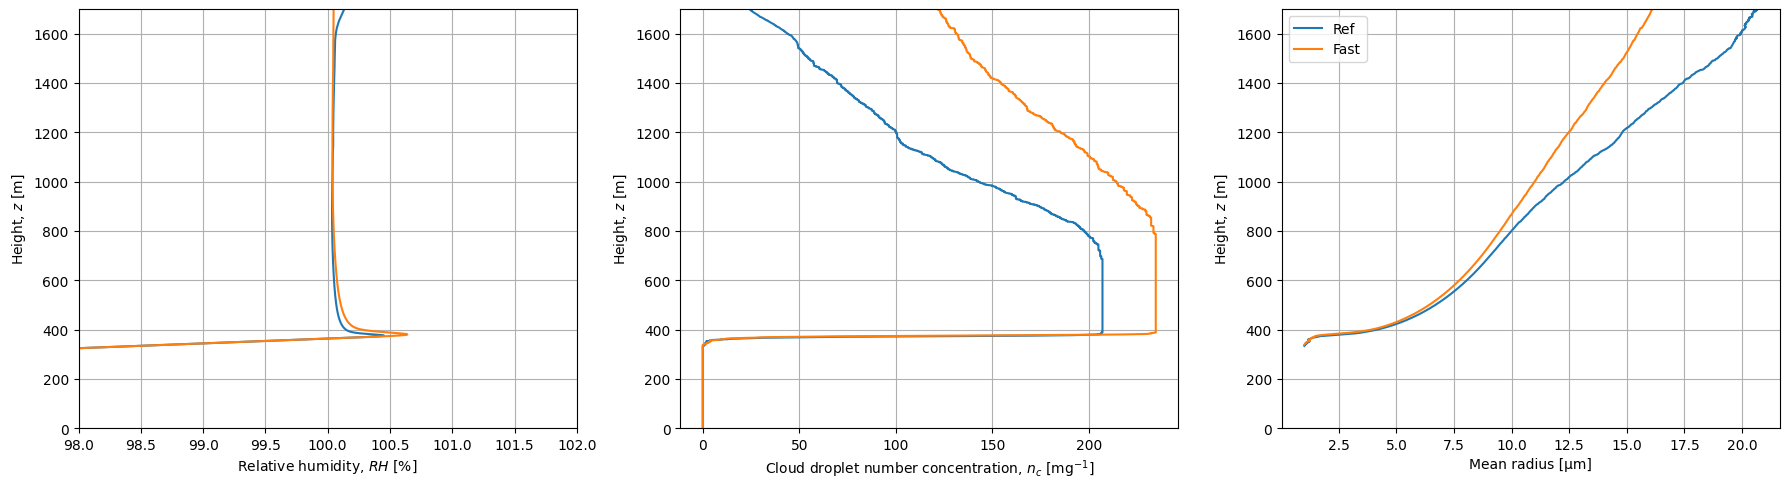

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].plot(fast_run['RH_parcel']*100, fast_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')
axs[0].set_xlim(98,102)

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].plot(fast_run['nc'], fast_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'], label="Ref")
axs[2].plot(fast_run['rc_liq_avg']*1e6, fast_run['z_parcel'], label="Fast")
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.set_ylim(fast_run['z_parcel'][0],fast_run['z_parcel'][-1])
    ax.grid()

plt.legend()

plt.tight_layout()
plt.show()

### Exercise 2.3: Importance of cloud thickness

The altitude of the cloud top corresponds to the thickness of the cloud for a given cloud base.

- Study the effect of cloud thickness on the microphysical composition of a cloud by comparing the simulation ‘reference_run’ to a simulation with a lower cloud top ‘thin_run’, where you set the cloud top height to 1/2 the reference.

- Explain your results by creating a conceptual diagram that relates cloud top, supersaturation, cloud droplet number and mean droplet radius. Which microphysical processes are important? How does your diagram reflect the equations of the parcel model?

In [26]:
# Reset w to original speed
w_parcel = ref_w

max_z = ref_z_max * 0.5 # m

In [27]:
thin_run \
    = create_results_dict(timesteps_function(
        dt, nt, do_condensation, do_collision, n_particles, \
        T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
        rm_spec, ascending_mode, display_mode, \
        mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
        kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
        entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
        qv_profiles, theta_profiles
    ))

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 1700.0    850.00   283.30   8.56      100.037   0.936     0.000     90.60     178.05    0.00      500     


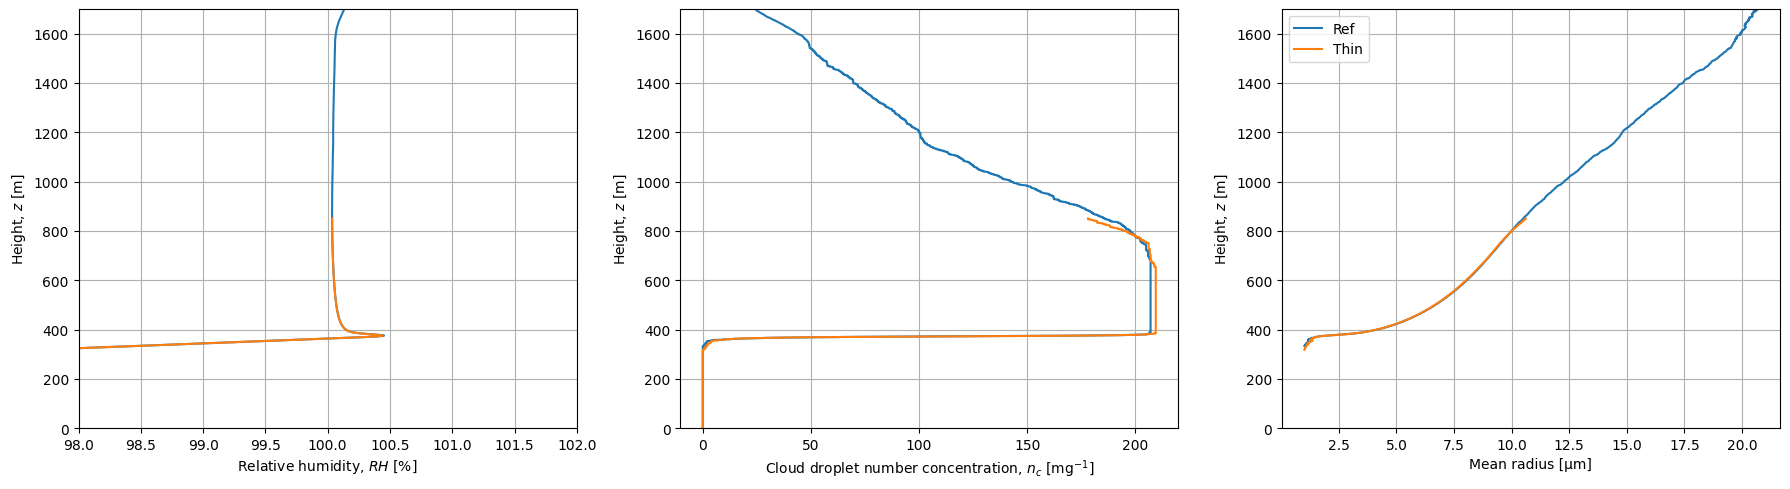

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))


# AX 1

axs[0].plot(reference_run['RH_parcel']*100, reference_run['z_parcel'])
axs[0].plot(thin_run['RH_parcel']*100, thin_run['z_parcel'])
axs[0].set_xlabel('Relative humidity, $RH$ [%]')
axs[0].set_xlim(98,102)

# AX 2

axs[1].plot(reference_run['nc'], reference_run['z_parcel'])
axs[1].plot(thin_run['nc'], thin_run['z_parcel'])
axs[1].set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

# AX 3

axs[2].plot(reference_run['rc_liq_avg']*1e6, reference_run['z_parcel'], label="Ref")
axs[2].plot(thin_run['rc_liq_avg']*1e6, thin_run['z_parcel'], label="Thin")
axs[2].set_xlabel('Mean radius [µm]')

for ax in axs:
    ax.set_ylabel('Height, $z$ [m]')
    ax.set_ylim(reference_run['z_parcel'][0],reference_run['z_parcel'][-1])
    ax.grid()

plt.legend()

plt.tight_layout()
plt.show()

### Exercise 2.4: Aerosol vs. meteorology

Based on your experiments, comment on the following statement:

" The aerosol conditions are more important than meteorological factors like updraft and cloud thickness in controlling the droplet number concentration. "

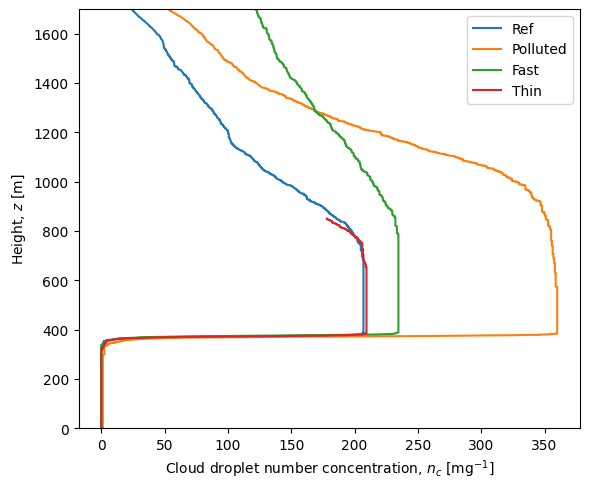

In [29]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(reference_run['nc'], reference_run['z_parcel'], label="Ref")
ax.plot(polluted_run['nc'], polluted_run['z_parcel'], label="Polluted")
ax.plot(fast_run['nc'], fast_run['z_parcel'], label="Fast")
ax.plot(thin_run['nc'], thin_run['z_parcel'], label="Thin")
ax.set_xlabel('Cloud droplet number concentration, $n_c$ [mg$^{-1}$]')

ax.set_ylabel('Height, $z$ [m]')

ax.set_ylim(fast_run['z_parcel'][0],fast_run['z_parcel'][-1])

plt.legend()

plt.tight_layout()
plt.show()

## Exercise 3: Cloud albedo and precipitation

The microphysical composition of a cloud as described by the profiles/ timeseries of liquid number concentration and droplet radii determine the cloud albedo and the amount of rain formed in the cloud. The following code box gives you an example of how to calculate albedo and rain for a given simulation.

- Describe how aerosol, updraft and cloud thickness influence albedo and rain.

- Can you explain your observations, when taking into account that:

    - The amount of rain corresponds to the total mass of all big droplets in a cloud.
    - Cloud albedo depends on the total surface of all the droplets in a cloud.

- Add albedo and rain to your conceptual diagrams from Exercise 2.

In [30]:
print(f"""
ALBEDO:

Reference run:\t{reference_run['albedo'][-1]:.3}
Polluted run:\t{polluted_run['albedo'][-1]:.3}
Fast run:\t{fast_run['albedo'][-1]:.3}
Thin run:\t{thin_run['albedo'][-1]:.3}

RWP (kg m-2):

Reference run:\t{rwp(reference_run, 0.5)[-1]*1e-3:.3}
Polluted run:\t{rwp(polluted_run, 0.5)[-1]*1e-3:.3}
Fast run:\t{rwp(fast_run, 1.0)[-1]*1e-3:.3}
Thin run:\t{rwp(thin_run, 0.5)[-1]*1e-3:.3}
""")


ALBEDO:

Reference run:	0.959
Polluted run:	0.965
Fast run:	0.966
Thin run:	0.857

RWP (kg m-2):

Reference run:	0.354
Polluted run:	0.283
Fast run:	0.0216
Thin run:	0.0

